In [1]:
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 50

In [2]:
# Import data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train,df_test])

df.columns = df.columns.str.lower()

In [3]:
# Datetime format: Creating year, month, day variable from date
def date_format(df_data):
    df_data['open date'] = df_data['open date'].apply(lambda x : datetime.strptime(x, '%m/%d/%Y'))
    df_data['open_year'] = df_data['open date'].apply(lambda x: x.year)
    df_data['open_month'] = df_data['open date'].apply(lambda x: x.month)
    df_data['open_day'] = df_data['open date'].apply(lambda x: x.day)
    return  df_data

### Exploratory Analysis

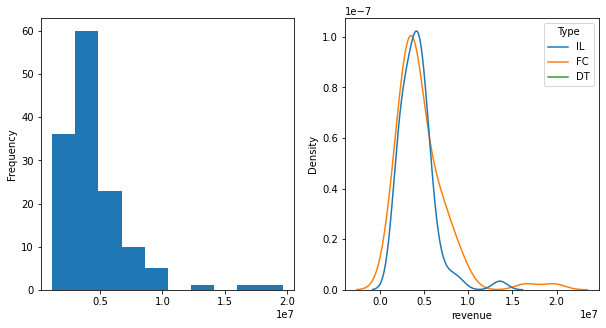

In [5]:
# Distribution of revenue between different restaurant types
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
df_train['revenue'].plot.hist()
plt.subplot(1,2,2)
sns.kdeplot(data=df_train, x='revenue', hue='Type')
plt.show()

In [8]:
# Remove outliers
df = df[df.revenue.le(11000000)]

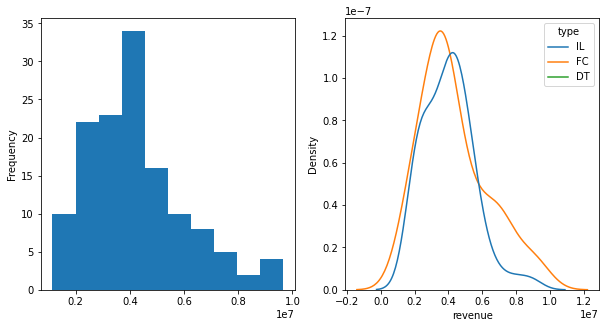

In [11]:
# Revenue after removing outliers
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
df.revenue[df.revenue.notnull()].plot.hist()
plt.subplot(1,2,2)
sns.kdeplot(data=df[df.revenue.notnull()], x='revenue', hue='type')
plt.show()

In [12]:
# Add year, month, day to train and test data
df = date_format(df)
# Classifying restaurant types into FC or IL
df.type[df.type.ne('FC')] = 'IL'
# Group cities other than Istanbul and Ankara into 1 category
df['city'][~df.city.isin(['İstanbul','Ankara'])] = 'Other'
# Drop unuseful columns
df.drop(columns=['id','open date'], inplace=True)

# Select features to drop for each restaurant type
col_drop_FC = df_train[df_train.Type.eq('FC')].mean()[lambda x: x<0.5].index.values
col_drop_IL = df_train[df_train.Type.ne('FC')].mean()[lambda x: x<0.5].index.values

# One-hot encode data
df_encoded = pd.get_dummies(df, columns=['type','open_year','open_month','open_day','city','city group'])

# Reseparate training from testing
df_train_encoded = df_encoded[df_encoded.revenue.notnull()]
df_test_encoded = df_encoded[df_encoded.revenue.isnull()].drop(columns='revenue')

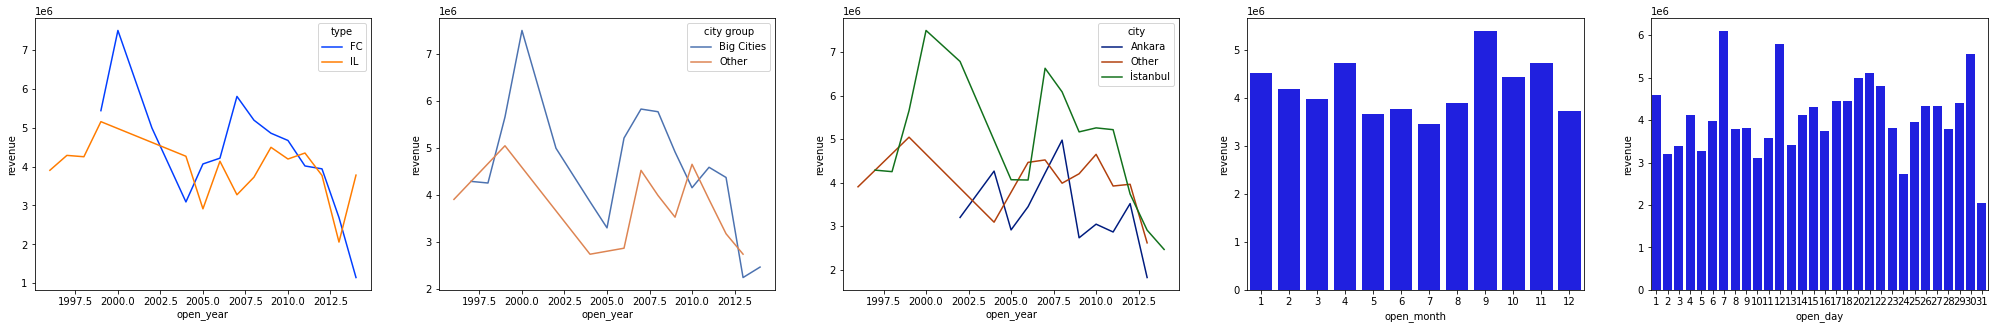

In [13]:
# Revenue on a time series basis
plt.figure(figsize=(35,5))

plt.subplot(1,5,1)
sns.lineplot(data=df[df.revenue.notnull()].groupby(['type','open_year'])['revenue'].mean().reset_index(), x='open_year', y='revenue', hue='type', palette='bright')
plt.subplot(1,5,2)
sns.lineplot(data=df[df.revenue.notnull()].groupby(['city group','open_year'])['revenue'].mean().reset_index(), x='open_year', y='revenue', hue='city group', palette='deep')
plt.subplot(1,5,3)
sns.lineplot(data=df[df.revenue.notnull()].groupby(['city','open_year'])['revenue'].mean().reset_index(), x='open_year', y='revenue', hue='city', palette='dark')
plt.subplot(1,5,4)
sns.barplot(data=df[df.revenue.notnull()].groupby('open_month')['revenue'].mean().reset_index(), x='open_month', y='revenue',color='blue')
plt.subplot(1,5,5)
sns.barplot(data=df[df.revenue.notnull()].groupby('open_day')['revenue'].mean().reset_index(), x='open_day', y='revenue',color='blue')
plt.show()

- There appears to be revenue patterns on a yearly, monthly and daily basis. Therefore it justifies including such variables in the model.

### Build model using Gradient Boosting Regressor

In [14]:
# Create function to return trained and optimized model
def optimize_and_fit(X,Y):
    param_grid = {'learning_rate': [0.0001],
              'n_estimators': np.arange(100,510,10),
              'max_depth': np.arange(3,11,1),
              'subsample': [0.5,0.7,0.9],
              'min_samples_split': np.arange(2,11),
              'min_samples_leaf': np.arange(1,11)
    }
    grid_obj = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, scoring='neg_root_mean_squared_error',cv=5)
    grid_obj.fit(X, Y)
    # Fit train data to optimized model
    optimized_model = grid_obj.best_estimator_
    optimized_model.fit(X, Y)
    return optimized_model

In [15]:
# Identify independent and dependent variable and split data
x = df_train_encoded.drop(columns=['revenue'])
y = df_train_encoded[['revenue']]
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.3, random_state=123)

# Scale data separately for train and validation sets
f_scale = StandardScaler()
x_train_scaled = f_scale.fit_transform(x_train)
x_val_scaled = f_scale.transform(x_val)

t_scale = StandardScaler()
y_train_scaled = t_scale.fit_transform(y_train).reshape(y_train.shape[0],)
y_val_scaled = t_scale.transform(y_val).reshape(y_val.shape[0],)

In [ ]:
# Train and optimize model for FC prediction
optimized_combined_model = optimize_and_fit(x_train_scaled, y_train_scaled)

In [ ]:
# Print tuned model parameters
optimized_combined_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.0001,
 'loss': 'ls',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 470,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.7,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Predict and score on validation set
y_pred = t_scale.inverse_transform(optimized_combined_model.predict(x_val_scaled))
print('RMSE:',mean_squared_error(y_val,y_pred, squared=False))
print('R2:',r2_score(y_val,y_pred))

RMSE: 1623716.2924993276
R2: 0.009298325004011843


### Make prediction on test set

In [305]:
x_test_scaled = f_scale.transform(df_test_encoded)
y_test_pred = t_scale.inverse_transform(optimized_combined_model.predict(x_test_scaled))
df_test['predicted_revenue'] = y_test_pred

In [312]:
df_test[['predicted_revenue']].round()

,predicted_revenue
0,4209834.0
1,4176158.0
2,4227795.0
3,4178167.0
4,4237898.0
...,...
99995,4250378.0
99996,4146995.0
99997,4257114.0
99998,4257381.0
